In [1]:
import numpy
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE.Coefficient import *
from PDE.utils import *
from PDE.BoundaryShape import *
from PDE.Solver import *
from PDE.Solver.constant.wos_constant import Particle
from PDE import Float,Point2f, GreenSampling, Split

In [2]:
green = GreenSampling.Polynomial
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 0
epsilon = 1e-3
use_accel = True
split = Split.Normal

In [3]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 0

def source(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)
f = FunctionCoefficient("f", source_p, source)

In [4]:


def boundary(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]
parameters1_d = {}
parameters1_d["freq"] = 1
parameters1_d["bias"] = 6
parameters1_d["scale"] = 12
parameters2_d = {}
parameters2_d["freq"] = 8
parameters2_d["bias"] = 4
parameters2_d["scale"] = 8

dirichlet1 = FunctionCoefficient("dirichlet", parameters1_d, boundary)
dirichlet2 = FunctionCoefficient("dirichlet", parameters2_d, boundary)


#dirichlet1 = ConstantCoefficient("dirichlet1", 2)
#dirichlet2 = ConstantCoefficient("dirichlet1", )
shape = load_bunny(scale = 1, dirichlet = [dirichlet1, dirichlet2], neumann = [ConstantCoefficient("neumann", 10)], epsilon = epsilon, conf= 3)

In [5]:
bbox = [[-1, -1], [1, 1]]
resolution_image = [256, 256]
spp_image = 256


res = 128
spp_boundary = 2 ** 18

σ = ConstantCoefficient("screening", 10)


comp_origin = [0.2, -0.2]
comp_radius = 0.2
computation_shape = CircleShape(origin = comp_origin, radius = comp_radius, epsilon = epsilon)
grad_zero_points1 = computation_shape.create_boundary_points(distance = 0, res = 128, spp = 2)[0]
grad_zero_points2 = shape.create_neumann_points(resolution = 64, spp = 2)
grad_zero_points =Point2f(np.hstack([grad_zero_points1.numpy(), grad_zero_points2.numpy()]))

out_val = 1
image = np.arange(32.0) / 32
image = np.tile(image, (32, 1))
image *= 2
image += out_val
α = TextureCoefficient("diffusion", bbox = bbox, tensor_np = image, out_val=out_val, grad_zero_points=grad_zero_points)
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f)


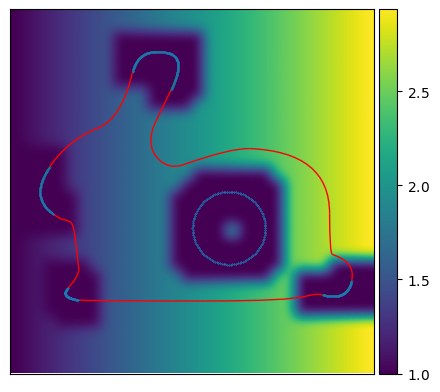

In [6]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
ress = [512, 512]
α.visualize(ax, bbox, ress)
shape.sketch(ax, bbox, ress)
grad_points_s = point2sketch(grad_zero_points, bbox, ress).numpy()
ax.scatter(grad_points_s[0], grad_points_s[1], s = 0.1)

0 : 16777216 -> 204493
1 : 204493 -> 33116
2 : 33116 -> 6117
3 : 6117 -> 1158
4 : 1158 -> 241
5 : 241 -> 53
6 : 53 -> 14
7 : 14 -> 1
8 : 1 -> 0


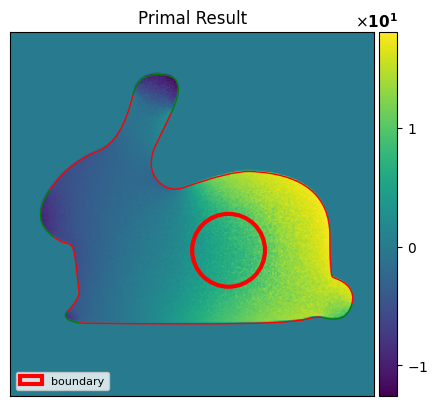

In [7]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WostVariable(data_holder, green_sampling=green, use_accelaration=use_accel)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image_0, tensor = create_image_from_result(L, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0[conf_vis], ax1)
ax1.set_title("Primal Result")
shape.sketch(ax1, bbox, resolution_image)
computation_shape.sketch(ax1, bbox, resolution_image)
ax1.legend(loc = "lower left", fontsize = 8)

In [8]:
dr.width(p.thrown)
dr.sum(dr.select(p.thrown, 1, 0))

[0]

In [9]:
dr.width(p.points)

1

In [10]:
points, _, normal_dir = computation_shape.create_boundary_points(distance=0, res = res, spp = spp_boundary)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers, split = split)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_dirichlet = computation_shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 1717634
1 : 1717634 -> 311425
2 : 311425 -> 60160
3 : 60160 -> 12115
4 : 12115 -> 2399
5 : 2399 -> 501
6 : 501 -> 95
7 : 95 -> 17
8 : 17 -> 5
9 : 5 -> 2
10 : 2 -> 1
11 : 1 -> 0


In [11]:
normal_dir = -dr.normalize(points -Point2f(comp_origin))
L, p = wos.solve(points_in = points, derivative_dir = normal_dir,  conf_numbers=conf_numbers, split = split)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_neumann= computation_shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 1924874
1 : 1924874 -> 349033
2 : 349033 -> 68242
3 : 68242 -> 13740
4 : 13740 -> 2743
5 : 2743 -> 545
6 : 545 -> 109
7 : 109 -> 23
8 : 23 -> 4
9 : 4 -> 0


Text(0.5, 1.0, 'Dirichlet Cut')

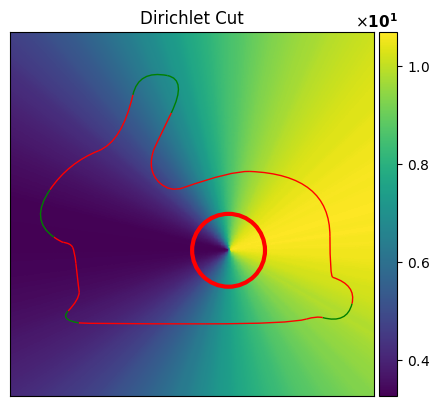

In [12]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
computation_shape.sketch(ax, bbox, resolution_image)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

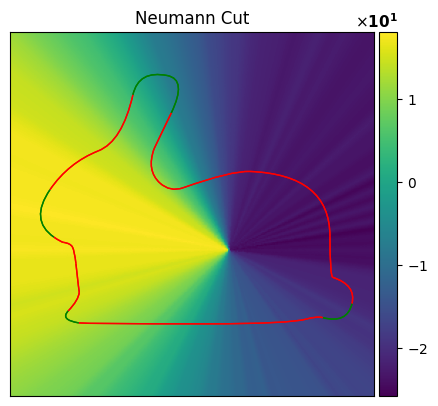

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann[0].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.set_title("Neumann Cut")

In [14]:
angle_partition1 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([1, 0, 1, 0])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([0, 1, 0, 1])
shape1 = CircleShape(origin=comp_origin, radius=comp_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
data_holder1 = DataHolder(shape = shape1, α = α, σ = σ, f=f)

shape2 = CircleShape(origin=comp_origin, radius=comp_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
data_holder2 = DataHolder(shape = shape2, α = α, σ = σ, f=f)

In [15]:
bbox_ = [[comp_origin[0] - 1.05 * comp_radius, comp_origin[1] -1.05 * comp_radius], [comp_origin[0] + 1.05 * comp_radius, comp_origin[1] + 1.05 * comp_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostVariable(data_holder1, green_sampling = green, use_accelaration=use_accel)
L1, _ = wos1.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostVariable(data_holder2, green_sampling = green, use_accelaration=use_accel)
L2, _ = wos2.solve(points_in = points, conf_numbers = conf_numbers, split = split)
image2, tensor = create_image_from_result(L2, resolution_image)

0 : 16777216 -> 270132
1 : 270132 -> 48359
2 : 48359 -> 8512
3 : 8512 -> 1461
4 : 1461 -> 258
5 : 258 -> 44
6 : 44 -> 8
7 : 8 -> 2
8 : 2 -> 1
9 : 1 -> 0
0 : 16777216 -> 542787
1 : 542787 -> 114591
2 : 114591 -> 23874
3 : 23874 -> 4973
4 : 4973 -> 1002
5 : 1002 -> 200
6 : 200 -> 40
7 : 40 -> 9
8 : 9 -> 2
9 : 2 -> 1
10 : 1 -> 0


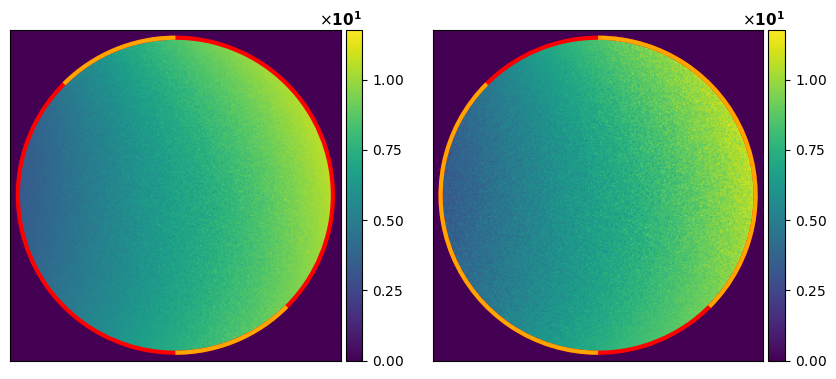

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
max_val = max(image1.max(), image2.max())
min_val = min(image1.min(), image2.min())
range_ = [min_val, max_val]
plot_image(image1[conf_vis], ax1, input_range=range_)
shape1.sketch(ax1, bbox_, resolution_image)
plot_image(image2[conf_vis], ax2, input_range=range_)
shape2.sketch(ax2, bbox_, resolution_image)

Mean:
-0.010434169
Variance:
0.0813378


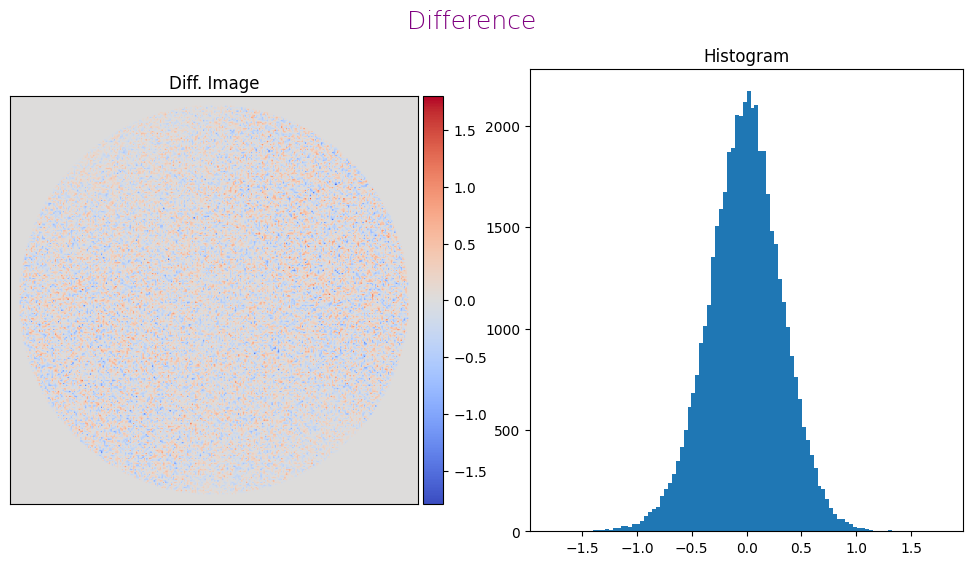

In [17]:
sketch_diff(image1[conf_vis], image2[conf_vis], max_range = 1000)